In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import json
import requests

# using the API endpoint to get the user data in DynamoDB
URL = 'https://smart-parking-iotprogramming.herokuapp.com/api/users'
obj = requests.get(URL).json()
users = obj['users']

In [3]:
# convert the json to DataFrame
raw_df = pd.DataFrame(columns=['user_id', 'ts', 'user_fee'])
for user in users:
    obj = {
        'user_id': user['user_id'],
        'ts': user['ts_payment'],
        'user_fee': user['user_fee']
    }
    raw_df = raw_df.append(obj, ignore_index=True)
    
raw_df

,user_id,ts,user_fee
0,896.0,2020-05-26 14:48:10.734,24
1,3396.0,2020-05-29 15:34:04,15
2,1710.0,2020-06-02 03:24:00,21
3,96.0,2020-06-01 14:42:37.218,31.5
4,123.0,2020-05-27 17:19:41,20
5,6454.0,2020-05-26 13:37:36.258,22
6,4730.0,2020-05-25 12:11:51.264,17
7,987.0,2020-05-28 15:06:08,15
8,1915.0,2020-06-02 12:23:33,21
9,1102.0,2020-06-01 13:58:41.45,22


In [4]:
# Convert the datatypes accordingly
# set the date to datetime format
raw_df['user_fee'] = raw_df['user_fee'].astype('float64')
raw_df['ts'] = pd.to_datetime(raw_df['ts'])
raw_df.dtypes

user_id            float64
ts          datetime64[ns]
user_fee           float64
dtype: object

In [5]:
# group the data based on the day
g = raw_df.groupby(raw_df['ts'].dt.date)
tdf = pd.DataFrame(columns=['ts', 'user_fee', 'total_user'])

# create a new dataset that contains the day, average user fee and total user
for k in g.groups.keys():
    tdf = tdf.append({
        'ts': k,
        'user_fee': g.get_group(k).mean()['user_fee'],
        'total_user': g.get_group(k).count()['user_id']
    }, ignore_index=True)
tdf

,ts,user_fee,total_user
0,2020-05-25,16.000000,2
1,2020-05-26,20.750000,4
2,2020-05-27,20.000000,1
3,2020-05-28,15.000000,1
4,2020-05-29,15.000000,1
5,2020-05-30,10.000000,1
6,2020-06-01,27.166667,3
7,2020-06-02,21.000000,3


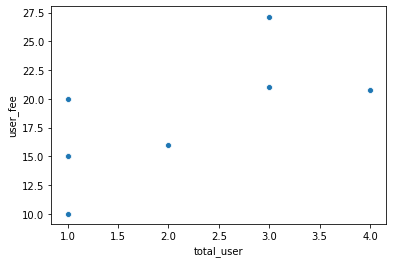

In [6]:
# plot the dataframe
sns.scatterplot(data=tdf, x='total_user', y='user_fee')

In [7]:
# define the X and Y
X = tdf['total_user'].values.reshape(-1,1)
y = tdf['user_fee']

In [8]:
from sklearn.linear_model import LinearRegression

# train the linear model
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

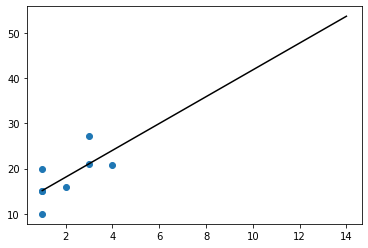

In [9]:
# plot the actual data and the prediction
plt.scatter(X, y)
test_X = np.array(list(range(1, 15)))
test_X = test_X.reshape(-1, 1)
plt.plot(test_X, model.predict(test_X),color='k')

In [10]:
raw_df['ts'] = pd.to_datetime(raw_df['ts'])
raw_df['day'] = raw_df['ts'].dt.weekday_name
raw_df

,user_id,ts,user_fee,day
0,896.0,2020-05-26 14:48:10.734,24.0,Tuesday
1,3396.0,2020-05-29 15:34:04.000,15.0,Friday
2,1710.0,2020-06-02 03:24:00.000,21.0,Tuesday
3,96.0,2020-06-01 14:42:37.218,31.5,Monday
4,123.0,2020-05-27 17:19:41.000,20.0,Wednesday
5,6454.0,2020-05-26 13:37:36.258,22.0,Tuesday
6,4730.0,2020-05-25 12:11:51.264,17.0,Monday
7,987.0,2020-05-28 15:06:08.000,15.0,Thursday
8,1915.0,2020-06-02 12:23:33.000,21.0,Tuesday
9,1102.0,2020-06-01 13:58:41.450,22.0,Monday


In [11]:
raw_df.groupby('day')['user_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
Friday,1.0,15.000000,NaN,15.0,15.0,15.0,15.0,15.0
Monday,5.0,22.700000,7.032069,15.0,17.0,22.0,28.0,31.5
Saturday,1.0,10.000000,NaN,10.0,10.0,10.0,10.0,10.0
Thursday,1.0,15.000000,NaN,15.0,15.0,15.0,15.0,15.0
Tuesday,7.0,20.857143,2.794553,15.0,21.0,21.0,22.0,24.0
Wednesday,1.0,20.000000,NaN,20.0,20.0,20.0,20.0,20.0


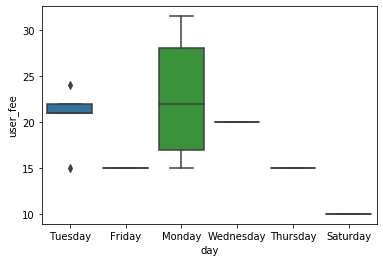

In [12]:
sns.boxplot(data=raw_df, x="day", y="user_fee")

In [13]:
from scipy import stats

print('Variance for consumable items:', stats.tvar(raw_df[raw_df['day'] == 'Monday']['user_fee']))
print('Variance for non-consumable items:', stats.tvar(raw_df[raw_df['day'] == 'Tuesday']['user_fee']))

Variance for consumable items: 49.45
Variance for non-consumable items: 7.809523809523811


In [15]:
monday = raw_df[raw_df['day'] == 'Monday']['user_fee']
tuesday = raw_df[raw_df['day'] == 'Tuesday']['user_fee']

s, p_val = stats.ttest_ind(monday, tuesday, equal_var=False)
print('p-value: ', p_val)

p-value:  0.6029019044576913
